In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from faster_rcnn.utils.datasets.voc.voc import VOCDetection
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from faster_rcnn.utils.datasets.data_generator import CocoGenerator
from faster_rcnn.utils.datasets.data_generator import Enqueuer
from torch.optim import SGD, RMSprop, Adam

from faster_rcnn.faster_rcnn import FasterRCNN
from pycrayon import CrayonClient
import torch
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont


/data
/data/data/mscoco


In [3]:
root = '/data'
ds = VOCDetection(root, 'train')
print(len(ds))

19172


In [5]:
def imshow(inp, gt_boxes=[], predict_boxes = []):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig,ax = plt.subplots(1, figsize=(20, 10))

    ax.imshow(inp)
    for i, box in enumerate(gt_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=2,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        
    for i, box in enumerate(predict_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=1,edgecolor='g',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.pause(0.001)  # pause a bit so that plots are updated


In [6]:
data_gen = CocoGenerator(data=ds, batch_size=1, shuffle=True, seed=22)
queue = Enqueuer(generator=data_gen, use_multiprocessing=False)
queue.start(max_queue_size=20, workers=4)


In [7]:
t = queue.get()
blobs = t.next()
gt_boxes = blobs['boxes']
gt_classes = blobs['gt_classes']

In [9]:
val_ds = VOCDetection(root, 'val')
val_data_gen = CocoGenerator(data=val_ds, batch_size=1, shuffle=True, seed=22)
val_queue = Enqueuer(generator=data_gen, use_multiprocessing=False)
val_queue.start(max_queue_size=10,workers=4)
t2 = val_queue.get()

In [10]:
categories = ds.classes
print(categories)

['__background__', u'1077', u'1017', u'1506', u'1028', u'62412', u'80', u'1405', u'1217', u'1027', u'1258', u'1529', u'150', u'1133', u'616', u'37', u'1166', u'1143', u'1221', u'1173', u'193', u'1249', u'121', u'3', u'13303', u'100', u'1185', u'1022', u'1439', u'10007', u'1236', u'1868', u'1101', u'1251', u'1065', u'2053', u'75', u'15', u'1134', u'1064', u'1647', u'92', u'41', u'227', u'226', u'10970', u'1423', u'1243', u'59', u'12071', u'1058', u'1247', u'145', u'160', u'1560', u'62420', u'1009', u'10077', u'93_leaf', u'93_fruit', u'93_flower', u'136', u'50', u'14979', u'1585', u'61', u'38', u'224', u'1107', u'82', u'1136', u'1160', u'233', u'1036', u'1271', u'10922', u'1057', u'1837', u'1037', u'10610', u'1248', u'860', u'8', u'10602', u'1203', u'10564', u'179', u'234', u'1226', u'1085', u'1382', u'10', u'1088', u'10227', u'195', u'30', u'13082', u'1215']


In [11]:
net = FasterRCNN(categories, debug=False)
net.cuda()
net.train()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/anh/.torch/models/vgg16-397923af.pth
100.0%


FasterRCNN(
  (roi_pool): RoIPool(
  )
  (fc6): FC(
    (fc): Linear(in_features=25088, out_features=4096)
    (relu): ReLU(inplace)
  )
  (fc7): FC(
    (fc): Linear(in_features=4096, out_features=4096)
    (relu): ReLU(inplace)
  )
  (score_fc): FC(
    (fc): Linear(in_features=4096, out_features=98)
  )
  (bbox_fc): FC(
    (fc): Linear(in_features=4096, out_features=392)
  )
  (rpn): RPN(
    (features): Sequential(
      (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (10): Conv

In [12]:
params = filter(lambda x: x.requires_grad, net.parameters())

In [17]:
def eval(data_gen ,model, epochs):
    model.train()
    val_loss = 0

    for epoch in range(epochs):
        try:
            blobs = data_gen.next()
            im_data = blobs['tensor']
            im_info = blobs['im_info']
            gt_boxes = blobs['boxes']
            gt_classes = blobs['gt_classes']
            gt_boxes = np.hstack([gt_boxes , gt_classes[:, np.newaxis]])
            cls_prob, bbox_pred, rois = model(im_data, im_info, gt_boxes)
        except Exception as e:
            print e
            continue

        loss = model.loss
        val_loss += loss.data[0]

    return val_loss / epochs

def train(data_gen, val_data_gen, optimizer, lr_scheduler ,model, epochs, steps_per_epoch):
    exp_name = datetime.now().strftime('vgg16_%m-%d_%H-%M')
    cc = CrayonClient(hostname="crayon", port=8889)
    exp = cc.create_experiment(exp_name)
    model.train()
    train_loss = 0

    for epoch in range(epochs):
        for step in range(1, steps_per_epoch +1):
            lr_scheduler.step()
            try:
                blobs = data_gen.next()
                im_data = blobs['tensor']
                im_info = blobs['im_info']
                gt_boxes = blobs['boxes']
                gt_classes = blobs['gt_classes']
                gt_boxes = np.hstack([gt_boxes , gt_classes[:, np.newaxis]])
                cls_prob, bbox_pred, rois = model(im_data, im_info, gt_boxes)
            except Exception as e:
                print e
                continue
                
            loss = model.loss
            train_loss += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step % 100 == 0:
                log_text = 'step %d, image: %s, loss: %.4f' % (
                    step, blobs['im_name'], train_loss /(step))
                print(log_text)

                re_cnt = True
            if step % 5000 == 0 :
                val_loss = eval(val_data_gen ,model, 2000)
                exp.add_scalar_value('val_loss', val_loss, step=step)
                log_text = 'step %d, val_loss: %.4f' % (step, val_loss)
                print log_text

            if step % 10 == 0:
                exp.add_scalar_value('train_loss', train_loss / step, step=step)

            if step % 10000 == 0:
                torch.save(model.state_dict(), 'model_at_step_%s.pkl' % step)

In [14]:
optimizer = SGD(params, lr=1e-4, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler = StepLR(optimizer, step_size=1000, gamma=0.95)

In [ ]:
train(t, t2, optimizer=optimizer,lr_scheduler=exp_lr_scheduler, model=net, epochs=1, steps_per_epoch=180000)

step 100, image: 1507441110296_thum_1507441109821_thum_photo.jpg, loss: 1.7099
step 200, image: 1495110344461_thum_1495110343918_thum_photo.jpg, loss: 1.6740
step 300, image: 1495539604836_thum_1495539604137_thum_sample.jpg, loss: 1.6487
step 400, image: 1515550534933_thum_1515550534569_thum_sample.jpg, loss: 1.6534
step 500, image: 1497699591514_thum_1497699590971_thum_photo.jpg, loss: 1.6548
step 600, image: 1505742334132_thum_1505742333635_thum_sample.jpg, loss: 1.6465
step 700, image: 1502848772404_thum_1502848771906_thum_photo.jpg, loss: 1.6451
step 800, image: 1498910419626_thum_1498910419259_thum_sample.jpg, loss: 1.6449
step 900, image: 1516371035342_thum_1516371034945_thum_sample.jpg, loss: 1.6347
step 1000, image: 1494059654789_thum_1494059654440_thum_sample.jpg, loss: 1.6276
step 1100, image: 1473123772207_thum_1473123771821_thum_tmp.jpg, loss: 1.6209
step 1200, image: 1507953616774_thum_1507953616064_thum_photo.jpg, loss: 1.6232
step 1300, image: 1497409331268_thum_14974093

step 10300, image: 1499237999206_thum_1499237998788_thum_sample.jpg, loss: 1.6180
step 10400, image: 1468591539239_thum_1468591538864_thum_tmp.jpg, loss: 1.6178
step 10500, image: 1469100290632_thum_1469100123487_thum_DSC_0509[1].jpg, loss: 1.6184
step 10600, image: 1490835797751_thum_1490835796792_thum_sample.jpg, loss: 1.6182
step 10700, image: 1478135485994_thum_1478135485599_thum_sample.jpg, loss: 1.6180
step 10800, image: 1474533229725_thum_1474533229435_thum_sample.jpg, loss: 1.6177
step 10900, image: 1505031066771_thum_1505031065688_thum_sample.jpg, loss: 1.6184
step 11000, image: 1481542113752_thum_1481542113022_thum_tmp.jpg, loss: 1.6187
step 11100, image: 1509250045244_thum_1509250044227_thum_photo.jpg, loss: 1.6186
step 11200, image: 1506638919339_thum_1506638918946_thum_photo.jpg, loss: 1.6189
step 11300, image: 1495783905941_thum_1495783905408_thum_photo.jpg, loss: 1.6189
step 11400, image: 1495956408245_thum_1495956407844_thum_sample.jpg, loss: 1.6186
step 11500, image: 1

step 20400, image: 1491675731847_thum_1491675731419_thum_photo.jpg, loss: 1.6195
step 20500, image: 1511959056472_thum_1511958716643_thum_geacew.jpg, loss: 1.6193
step 20600, image: 1474267330218_thum_1474267329778_thum_sample.jpg, loss: 1.6196
step 20700, image: 1491624798437_thum_1491624797821_thum_photo.jpg, loss: 1.6195
step 20800, image: 1496223248365_thum_1496223246970_thum_photo.jpg, loss: 1.6193
step 20900, image: 1465966044403_thum_1465966044022_thum_sample.jpg, loss: 1.6192
step 21000, image: 1476583169339_thum_1476583168907_thum_tmp.jpg, loss: 1.6194
step 21100, image: 1432785636376_thum_1432785635595_thum_tmp.jpg, loss: 1.6190
step 21200, image: 1506949417386_thum_1506949416651_thum_photo.jpg, loss: 1.6190
step 21300, image: 1500011525498_thum_1500011525058_thum_sample.jpg, loss: 1.6191
step 21400, image: 1463048653868_thum_1463048653198_thum_tmp.jpg, loss: 1.6196
step 21500, image: 1512373922544_thum_1512373921203_thum_photo.jpg, loss: 1.6196
step 21600, image: 15112429571

step 30500, image: 1499579711963_thum_1499579711441_thum_sample.jpg, loss: 1.6200
step 30600, image: 1502509330413_thum_1502509329805_thum_photo.jpg, loss: 1.6199
step 30700, image: 1467434649313_thum_1467434648718_thum_tmp.jpg, loss: 1.6193
step 30800, image: 1449021853139_thum_1449021851386_thum_tmp.jpg, loss: 1.6195
step 30900, image: 1496977822475_thum_1496977822088_thum_sample.jpg, loss: 1.6193
step 31000, image: 1492507718756_thum_1492507718452_thum_photo.jpg, loss: 1.6195
step 31100, image: 1509014650319_thum_1509014649755_thum_photo.jpg, loss: 1.6197
step 31200, image: 1498383377251_thum_1498383376735_thum_photo.jpg, loss: 1.6196
step 31300, image: 1512083368483_thum_1512083368156_thum_photo.jpg, loss: 1.6197
step 31400, image: 1496785214427_thum_1496785213880_thum_photo.jpg, loss: 1.6197
step 31500, image: 1507974850148_thum_1507974849637_thum_photo.jpg, loss: 1.6194
step 31600, image: 1494734744552_thum_1494734744018_thum_sample.jpg, loss: 1.6194
step 31700, image: 1498955387

step 40600, image: 1497008695324_thum_1497008694775_thum_photo.jpg, loss: 1.6197
step 40700, image: 1413548347568_thum_1413548289424_thum_4680827327_5ca271cac2_o.jpg, loss: 1.6197
step 40800, image: 1493763804158_thum_1493763803642_thum_photo.jpg, loss: 1.6197
step 40900, image: 1469279552332_thum_1469279551964_thum_sample.jpg, loss: 1.6199
step 41000, image: 1466197061231_thum_1466197060757_thum_sample.jpg, loss: 1.6198
step 41100, image: 1481682476378_thum_1481682475594_thum_tmp.jpg, loss: 1.6196
step 41200, image: 1492329183788_thum_1492329183269_thum_photo.jpg, loss: 1.6197
step 41300, image: 1502960318958_thum_1502960318125_thum_sample.jpg, loss: 1.6199
step 41400, image: 1512553931040_thum_1512553930676_thum_sample.jpg, loss: 1.6200
step 41500, image: 1498087502845_thum_1498087502443_thum_photo.jpg, loss: 1.6198
step 41600, image: 1499294905184_thum_1499294904700_thum_photo.jpg, loss: 1.6200
step 41700, image: 1502580249690_thum_1502580249265_thum_photo.jpg, loss: 1.6202
step 418

step 50600, image: 1496558093020_thum_1496558092361_thum_photo.jpg, loss: 1.6197
step 50700, image: 1502003449242_thum_1502003448920_thum_sample.jpg, loss: 1.6201
step 50800, image: 1483538252848_thum_1483538252352_thum_sample.jpg, loss: 1.6202
step 50900, image: 1513762111968_thum_1513762111602_thum_sample.jpg, loss: 1.6200
step 51000, image: 1497134858503_thum_1497134857944_thum_photo.jpg, loss: 1.6202
step 51100, image: 1470444054393_thum_1470444054044_thum_tmp.jpg, loss: 1.6202
step 51200, image: 1496058583863_thum_1496058583184_thum_photo.jpg, loss: 1.6203
step 51300, image: 1476454914084_thum_1476454913673_thum_sample.jpg, loss: 1.6202
step 51400, image: 1498270144699_thum_1498270144273_thum_photo.jpg, loss: 1.6201
step 51500, image: 1478942796250_thum_1478942795422_thum_sample.jpg, loss: 1.6201
step 51600, image: 1476584506386_thum_1476584506055_thum_tmp.jpg, loss: 1.6199
step 51700, image: 1497261883884_thum_1497261883052_thum_photo.jpg, loss: 1.6200
step 51800, image: 14918045

step 60700, image: 1514173123378_thum_1514173122863_thum_photo.jpg, loss: 1.6198
step 60800, image: 1511190930724_thum_1511190930208_thum_photo.jpg, loss: 1.6198
step 60900, image: 1440751819111_thum_1440751818067_thum_tmp.jpg, loss: 1.6197
step 61000, image: 1460178802191_thum_1460178801796_thum_sample.jpg, loss: 1.6198
step 61100, image: 1485093744566_thum_1485093743882_thum_tmp.jpg, loss: 1.6196
step 61200, image: 1473848460906_thum_1473848460381_thum_tmp.jpg, loss: 1.6198
step 61300, image: 1476455091605_thum_1476455091296_thum_sample.jpg, loss: 1.6200
step 61400, image: 1502574628914_thum_1502574627582_thum_photo.jpg, loss: 1.6201
step 61500, image: 1514951894968_thum_1514951894093_thum_photo.jpg, loss: 1.6201
step 61600, image: 1498601717036_thum_1498601716416_thum_photo.jpg, loss: 1.6201


In [20]:
def result_show(inp, predicted_boxes=[], classes=[], scores=[]):
    font = ImageFont.truetype(font ='./font/FiraMono-Medium.otf', size=np.floor(3e-2 * 600 + 0.5).astype('int32'))
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    inp *= 255.0/inp.max() 
    
    fig,ax = plt.subplots(1, figsize=(20, 10))
    
    image = Image.fromarray(inp.astype('uint8'))
    
    draw = ImageDraw.Draw(image)
    for predicted_box, predicted_class, score in zip(predicted_boxes, classes, scores):
        label = '{} {:.2f}'.format(predicted_class, score)

        
        label_size = draw.textsize(label, font)
        
        left, top, right, bottom = predicted_box
        print(predicted_class, (left, top), (right, bottom))
        
        for i in range(3):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=(255,255,0))
        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])
        draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)])
        draw.text(text_origin, label, fill=(255, 255, 0), font=font)
    del draw
    ax.imshow(image)

In [67]:
pred_boxes, scores, classes, rois, blob = net.detect('./test_im/1501722572318_thum_1501722571789_thum_photo.jpg', thr=0.2)


(u'1868', (0.0, 215.80232440513134), (168.93032758586355, 576.72646812950563))
(u'92', (469.12996918930099, 0.0), (599.0, 580.36982720556421))
(u'234', (196.39019514018867, 376.44351380367709), (515.56914100765641, 599.0))
(u'15', (417.91125897556788, 124.31921965024982), (456.08793214869286, 221.79685862919189))


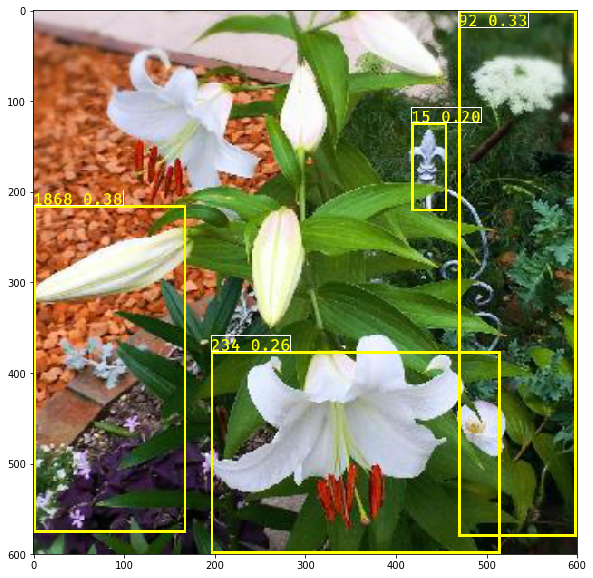

In [68]:
result_show(blob[0], pred_boxes, classes, scores)
